In [43]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
from scipy import stats
from matplotlib.ticker import FuncFormatter

import re

In [44]:
df = pd.read_csv("../output/figure_3_data.csv", index_col=0)
df = df.loc[df.apply(lambda row: len(row.unique())>1, axis=1),]
bacteria_names = df.index.tolist()

In [45]:
data_b = pd.read_csv("../output/figure_3b_data.csv")
data_b = data_b.rename(columns={"Unnamed: 0": "microbe_name"})
data_b["microbe_name"] = [re.sub(r'\d+$', '', x) for x in data_b["microbe_name"].tolist()]
data_b = data_b[data_b["j"]<=2]
data_b = data_b[data_b["j"]>-0.25]
data_b = data_b.loc[data_b["microbe_name"].isin(bacteria_names)]
data_b["microbe_name"] = [x.replace(" g__", "").replace("[", "").replace("]", "") for x in  data_b["microbe_name"].tolist()]
data_b["lower_LFC"] = -1.888 + data_b["j"] + data_b["median.effect"]
data_b["upper_LFC"] = -0.429 + data_b["j"] + data_b["median.effect"]
data_b["sig"] = [p < 0.05 for p in data_b["gtt.pval.BH.adj"]]

def myfunc(x):
  return slope * x + intercept

for key, gdf in data_b.groupby(["microbe_name"]):
    print(key[0])
    x = data_b.loc[data_b["microbe_name"]==key[0]]["j"].tolist()
    if key[0] in ["Selenomonas", "Schwartzia"]:
        y = data_b.loc[data_b["microbe_name"]==key[0]]["lower_LFC"].tolist()
    else:
        y = data_b.loc[data_b["microbe_name"]==key[0]]["lower_LFC"].tolist()
    slope, intercept, r, p, std_err = stats.linregress(x, y)
    data_b.loc[data_b["microbe_name"]==key[0],"fit_LFC"] = list(map(myfunc, x))

Haemophilus
Prevotella
Rothia
Schwartzia
Selenomonas
Streptococcus


/tmp/ipykernel_49595/421163417.py:18: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  pdf = df.T.replace(value_to_int)


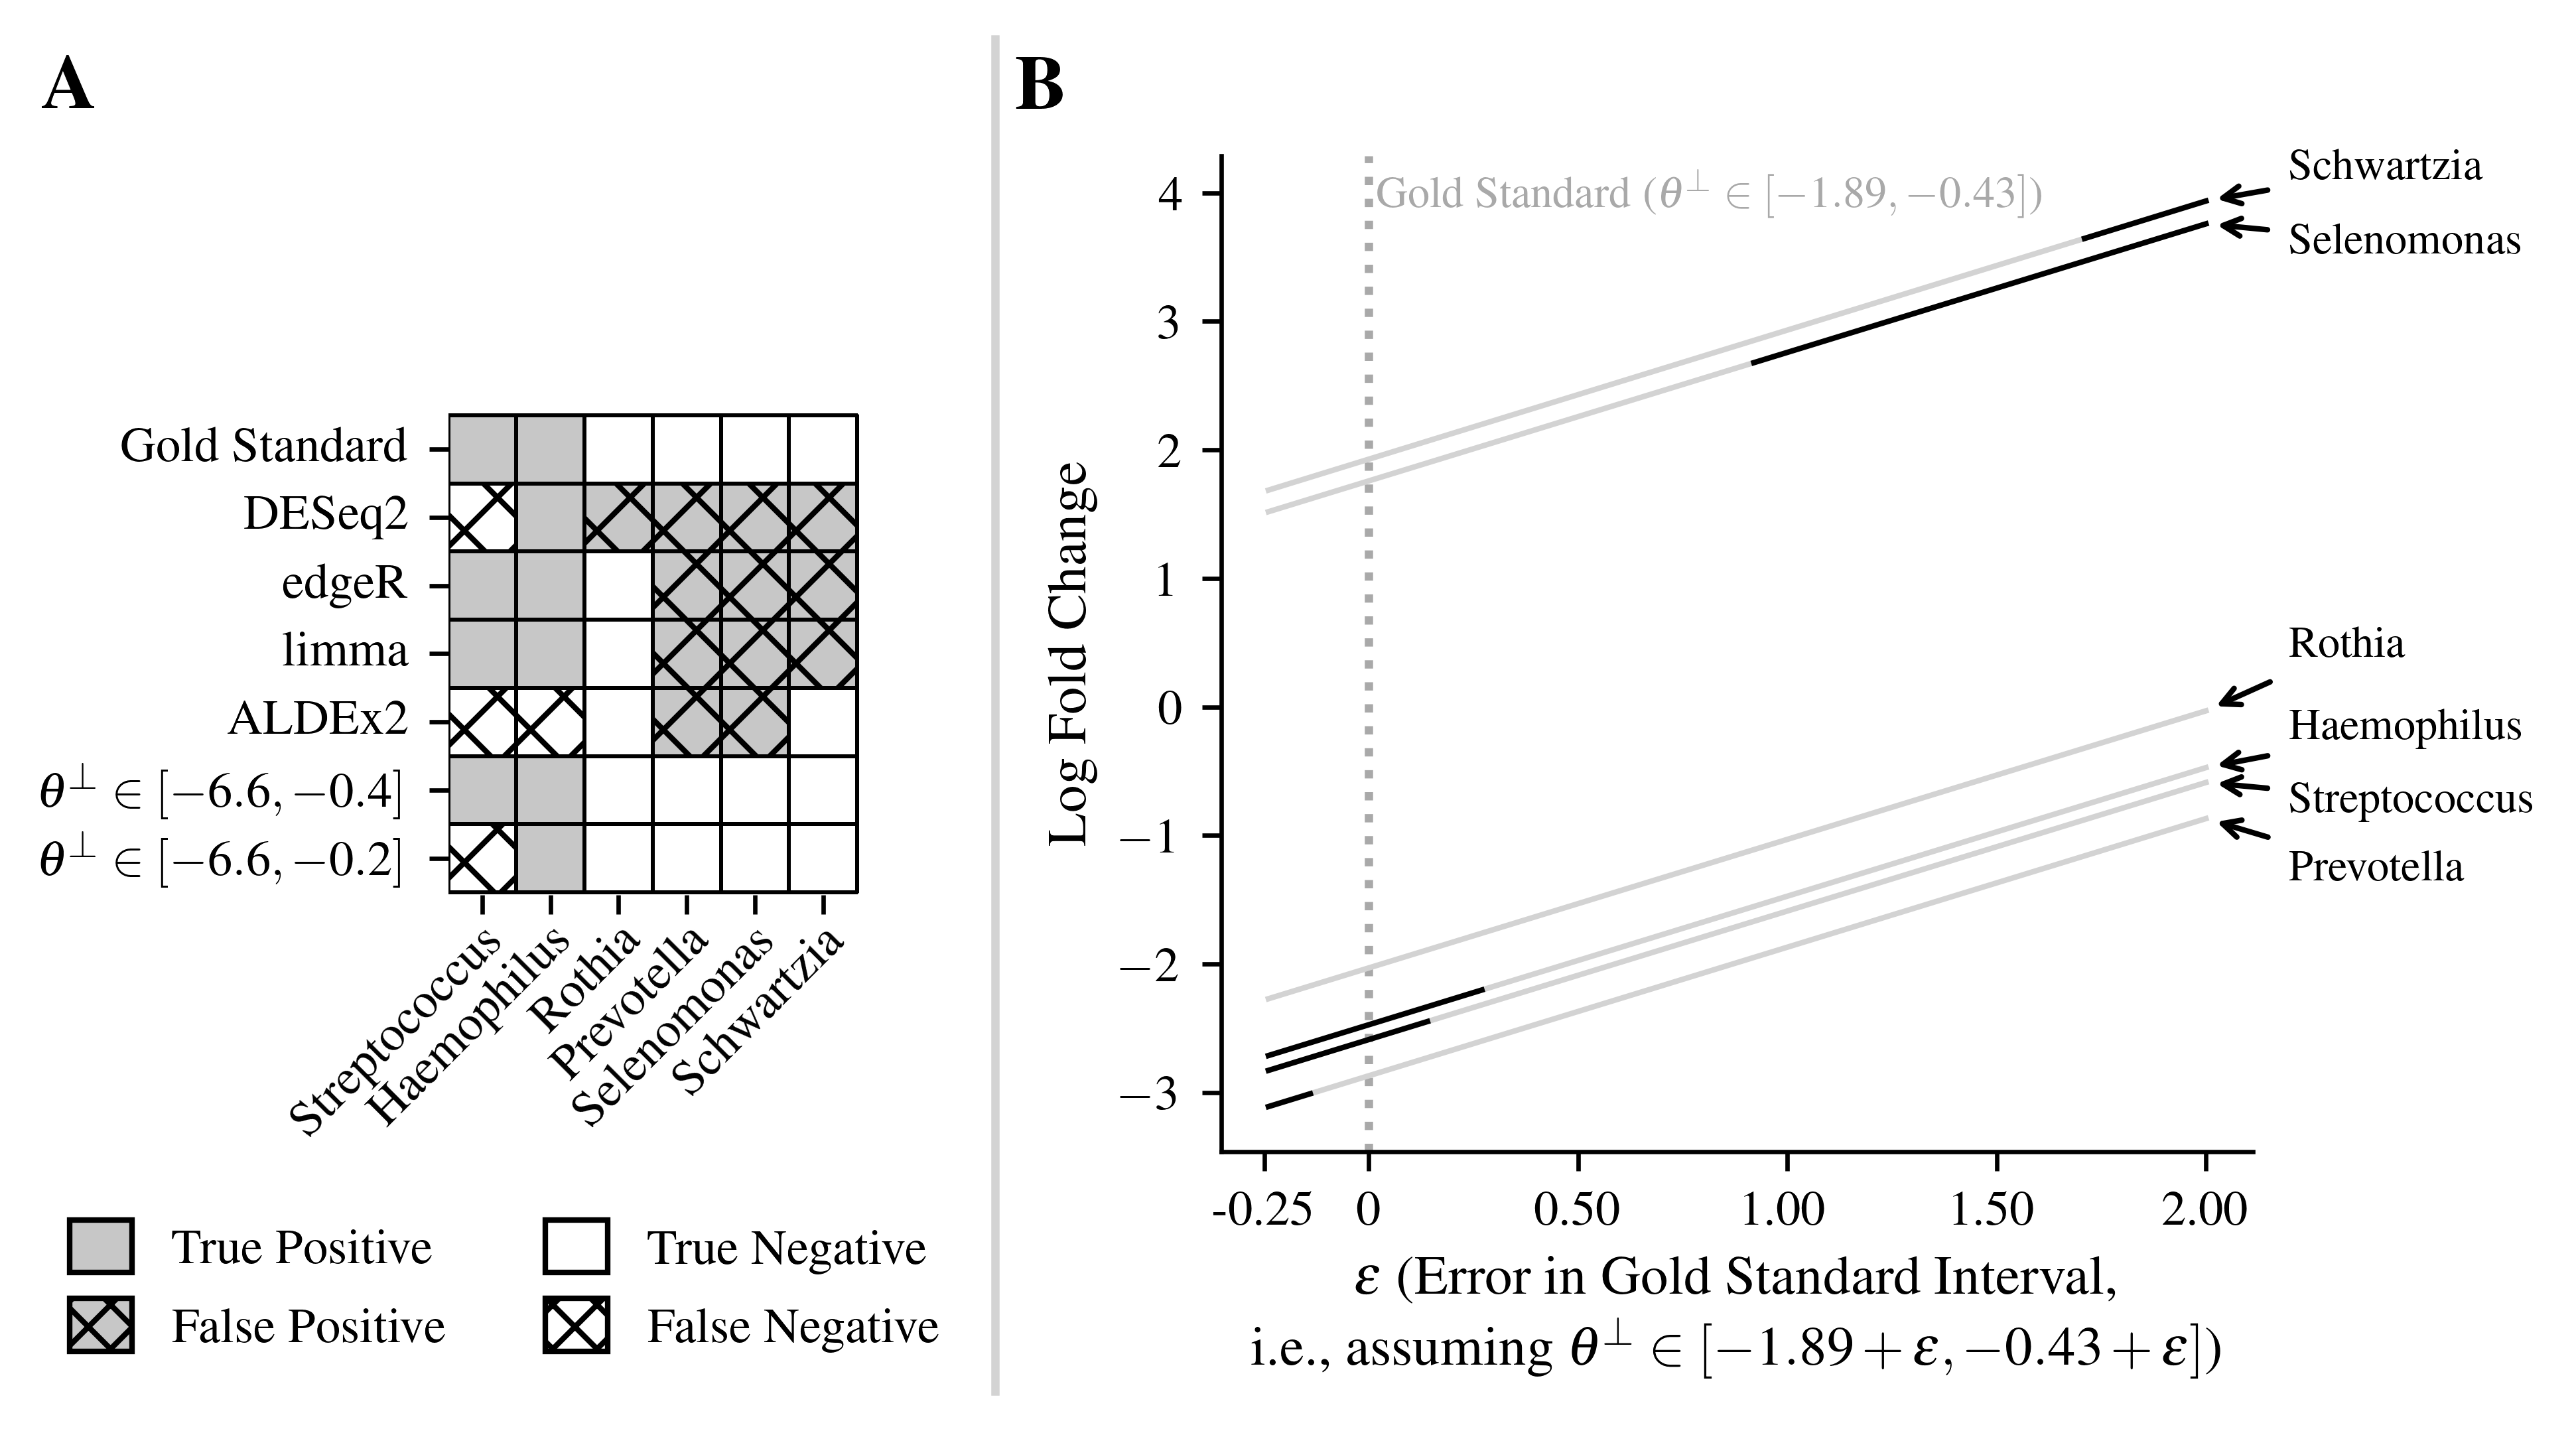

In [50]:
plt.rcParams["font.family"] = "Times"
plt.rcParams["text.usetex"] = True

width = 5.85
height = 3.25
dpi = 600
pw = width*dpi
ph = height*dpi

fig, axes = plt.subplots(figsize=(pw/dpi, ph/dpi), ncols=2, width_ratios=[1,2.5], dpi=dpi)
fig.subplots_adjust(wspace=0.5)

### PART 1
colors = ["#c7c7c7", "white", "white", "#c7c7c7"]
cmap = sns.color_palette(colors, 4)
value_to_int = {j:i for i,j in enumerate(pd.unique(df.values.ravel()))}
df = df[["gold_standard", "deseq2", "edger", "limma", "aldex2", "aldex2_con", "aldex2_lib"]]
pdf = df.T.replace(value_to_int)
pdf = pdf.rename({"gold_standard": "Gold Standard", "deseq2": "DESeq2", "edger": "edgeR", "aldex2": "ALDEx2",
                  "limma": "limma", "aldex2_con": "$\\theta^\\perp \\in [-6.6, -0.4]$",
                  "aldex2_lib": "$\\theta^\\perp \\in [-6.6, -0.2]$"}, axis=0)
pdf = pdf.rename(dict(zip(
    pdf.columns.tolist(), [x.replace(" g__", "").replace("[", "").replace("]", "") for x in  pdf.columns.tolist()])), axis=1)

sns.heatmap(data=pdf, linewidths=0.5, square=True, cmap=cmap, linecolor='black', cbar=False, ax=axes[0])
#ax.tick_params(axis='x', rotation=45, ha='right')
plt.setp(axes[0].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
bottom, top = axes[0].get_ylim()
left, right = axes[0].get_xlim()
axes[0].set_ylim(bottom+0.04, top-0.04)
axes[0].set_xlim(left, right+0.05)
axes[0].tick_params(axis='x', which='major', pad=0.5)
patterns = ['/', '', '/', '']
labels = ["TP", "FP", "TN", "FN"]
x = np.arange(df.T.shape[1] + 1)
y = np.arange(df.T.shape[0] + 1)

x = np.arange(pdf.shape[1]+1)
y = np.arange(pdf.shape[0]+1)
norm = plt.Normalize(pdf.values.min(), pdf.values.max())

axes[0].pcolor(x, y, np.where((pdf.isin([1, 3])), pdf.values, np.nan), alpha=0,
          hatch="xx")


legend_elements = [Patch(facecolor='#c7c7c7', edgecolor='black', label='True Positive'),
                   Patch(facecolor='#c7c7c7', edgecolor='black', label='False Positive', hatch="xxx"),
                   Patch(facecolor='white',   edgecolor='black', label='True Negative'),
                   Patch(facecolor='white',   edgecolor='black', label='False Negative', hatch="xxx")]

axes[0].legend(bbox_to_anchor=(1.3, -0.58), handles=legend_elements, frameon=False, ncol=2, fontsize=9,
               handlelength=1.25, handleheight=1.25)
axes[0].xaxis.set_tick_params(labelsize=9)
axes[0].yaxis.set_tick_params(labelsize=9)

### PART 1
for key, gdf in data_b.groupby(["microbe_name", "sig"]):
    if key[1]:
        color = "black"
    else:
        color = "lightgray"
    axes[1].plot("j", "fit_LFC", color=color, data=gdf, linewidth=1)
    
axes[1].spines[['right', 'top']].set_visible(False)
axes[1].set_xlabel("$\\epsilon$ (Error in Gold Standard Interval, \n i.e., assuming $\\theta^\\perp \\in [-1.89+\\epsilon, -0.43+\\epsilon]$)")
axes[1].set_ylabel("Log Fold Change")
axes[1].axvline(x=0, color="darkgrey", zorder=-1, linestyle="dotted")
axes[1].annotate("Gold Standard ($\\theta^\\perp \\in [-1.89,-0.43]$)", xy=(0.02 , 4),
                 color="darkgrey", fontsize=8,
                ha="left", va="center")
axes[1].xaxis.set_tick_params(labelsize=9)
axes[1].yaxis.set_tick_params(labelsize=9)
custom_ticks = [-0.25, 0, 0.5, 1, 1.5, 2]
axes[1].set_xticks(custom_ticks)
def specific_formatter(x, pos):
    if x == 0:
        return '0'  # Format 0 as '0'
    else:
        return f'{x:.2f}'  # Format other ticks with one decimal place
# Apply the formatter to the x-axis
axes[1].xaxis.set_major_formatter(FuncFormatter(specific_formatter))

offsets = [-0.15, 0.3, 0.5, -0.4, -0.15, 0.25]
count = 0
for i, row in data_b.tail(6).iterrows():
    axes[1].annotate(row["microbe_name"], xy=(row["j"], row["fit_LFC"]),
                xytext=(row["j"]+0.2, row["fit_LFC"]+offsets[count]),
                arrowprops=dict(facecolor="black", arrowstyle="->"),
                ha="left", va="center", fontsize=8)
    count += 1

axes[0].text(-0.85, 1.74, r"\textbf{A}", transform=axes[0].transAxes,
             fontsize=14, fontweight='bold', va='top', ha='right')
axes[1].text(-0.15, 1.1, r"\textbf{B}", transform=axes[1].transAxes,
             fontsize=14, fontweight='bold', va='top', ha='right')

plt.plot([0.36, 0.36], [-0.075, 0.97], color='lightgray', lw=1.5, transform=plt.gcf().transFigure, clip_on=False)
#plt.plot([-0.05, 0.5], [0.915, 0.915], color='lightgray', lw=1.5, transform=plt.gcf().transFigure, clip_on=False)

In [51]:
fig.savefig("../../figures/Figure_3.png", bbox_inches='tight')

In [40]:
data_b["upper_LFC"]

988    -1.367862
989    -1.252523
998    -0.813466
999    -1.651397
1008    2.975222
          ...   
9501    0.986822
9510    1.426533
9511    0.584282
9520    5.199221
9534    5.363211
Name: upper_LFC, Length: 1350, dtype: float64

In [41]:
data_b["lower_LFC"]

988    -2.826862
989    -2.711523
998    -2.272466
999    -3.110397
1008    1.516222
          ...   
9501   -0.472178
9510   -0.032467
9511   -0.874718
9520    3.740221
9534    3.904211
Name: lower_LFC, Length: 1350, dtype: float64